# Push BDL

### Dataset

In this notebook we will be demonstrating how to train a Bayesian Deep Neural Network using the simplest example, training a deep ensemble on a simple sine wave function.

$$
y = sin(2\pi x) + \epsilon
$$

$$
\epsilon \sim \mathcal{N}(0,\,0.05)\,
$$

In [1]:
from bdl import SineWithNoiseDataset
from bdl import SineDataset
import math

D = 1
batch_size = 12
N = 64
train_begin_radians = -2 * math.pi
train_end_radians = 2 * math.pi
test_begin_radians = -8 * math.pi
test_end_radians = 8 * math.pi
dataset = SineWithNoiseDataset(batch_size, N, D, train_begin_radians, train_end_radians)
oos_dataset = SineWithNoiseDataset(batch_size, N, D, test_begin_radians, test_end_radians)

```py
class SineWithNoiseDataset(Dataset):
    def __init__(self, batch_size, N, D, begin, end, noise_std=0.05):
        self.xs = torch.linspace(begin, end, batch_size * N * D).reshape(batch_size * N, D)
        true_ys = torch.sin(2 * torch.pi * self.xs[:, 0]).reshape(-1, 1)
        noise = torch.normal(0, noise_std, size=true_ys.size())
        self.ys = true_ys + noise

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

```

## Plotting the Dataset 

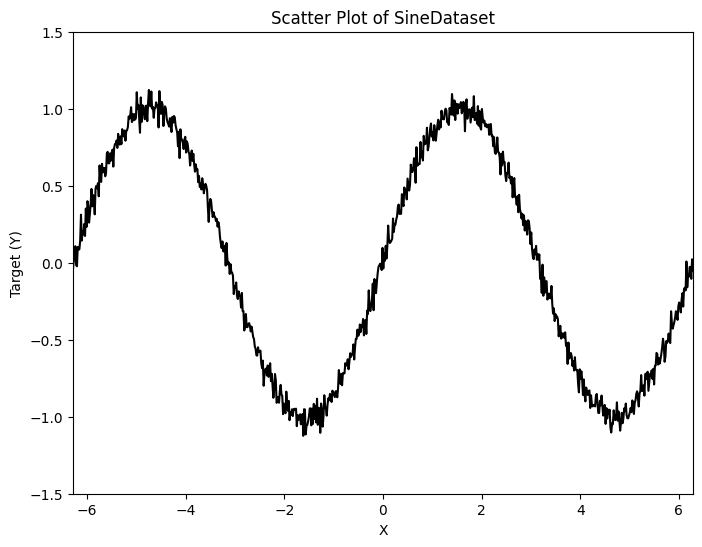

In [2]:
import matplotlib.pyplot as plt
# Extract the data
xs = dataset.xs
ys = dataset.ys
oos_xs = oos_dataset.xs
oos_ys = oos_dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c ="black")
plt.title('Scatter Plot of SineDataset')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.show()

### Neural Network

We create a simple neural network called BiggerNN, that consists of n MiniNNs. Each MiniNN contains two fully-connected layers of dimension $D$ and uses a ReLU activation function. This allows us to easily scale the size of the network to explore how network size affects our results.

In [19]:
from bdl import MiniNN
from bdl import BiggerNN

```py
class BiggerNN(nn.Module):
    def __init__(self, n, input_dim, output_dim, hidden_dim):
        super(BiggerNN, self).__init__()
        self.minis = []
        self.n = n
       
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        for i in range(0, n):
            self.minis += [MiniNN(hidden_dim)]
            self.add_module("mini_layer"+str(i), self.minis[-1])
        self.fc = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, x):
        x = self.input_layer(x)
        for i in range(0, self.n):
            x = self.minis[i](x)
        return self.fc(x)

class MiniNN(nn.Module):
    def __init__(self, D):
        super(MiniNN, self).__init__()
        self.fc1 = nn.Linear(D, D)
        self.fc2 = nn.Linear(D, D)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
```

### Training a Standard Neural Network (num_ensemble = 1)


### Hyperparameter selection
Before training our model, there are a some hyperparameters we must set. The number of layers (**n**) and hidden dimensions (**hidden_dim**) are the most consequential. In the cell below we show the effect of increasing the number hidden dimensions. Hidden dimensions refers to the number of nodes in each fully connected layer defined in MiniNN. BiggerNN is composed of n MiniNNs, with an input layer preceeding and an ouput layer after.

In the previous cell, we saved the output of our train_deep_ensemble function inside standard_params. train_deep_ensemble returns a list of all the parameters for each deep ensemble trained. Since we are only training one model, the list will contain only one parameter setting.

### Training Deep Ensembles (num_ensemble = 2, 4, 8, 16)

In [4]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

def train_ensemble(dataloader, model_class, n, input_dim, output_dim, hidden_dim, epochs, num_devices,num_ensembles ):
    cache_size=4

    return push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        model_class, n, input_dim, output_dim, hidden_dim,
        num_devices=num_devices,
        num_ensembles=num_ensembles,
        cache_size=cache_size
    )

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
input_dim = 1
output_dim = 1
hidden_dim = 64
n = 4
epochs = 100
num_devices = 2

two_particle_params = push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        model_class, n, input_dim, output_dim, hidden_dim,
        num_devices=num_devices,
        num_ensembles=2,
    )

four_particle_params = push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        model_class, n, input_dim, output_dim, hidden_dim,
        num_devices=num_devices,
        num_ensembles=4
    )

eight_particle_params =push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        model_class, n, input_dim, output_dim, hidden_dim,
        num_devices=num_devices,
        num_ensembles=8
    )


cache_size:  4


 99%|█████████▉| 99/100 [00:57<00:00,  1.85it/s]

cache_size:  4


 99%|█████████▉| 99/100 [01:32<00:00,  1.09it/s]

cache_size:  4


100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


# Get ensemble models
In the cell below we initialize our trained models by creating new instances of the BiggerNN class and assinging the parameters returned from train_deep_ensemble

In [13]:
def get_ensemble_models(paramList, num_ensembles, n, input_dim, hidden_dim):
    models = []
    for i in range(num_ensembles):
        model = BiggerNN(n, input_dim, output_dim, hidden_dim)
        
        # Check if the number of parameters in the list matches the number of model parameters
        if len(paramList[i]) != len(list(model.parameters())):
            print("The number of parameters in the list does not match the number of model parameters.")
        else:
            # Iterate through the model parameters and assign values from the list
            for model_param, param_value in zip(model.parameters(), paramList[i]):
                model_param.data = param_value

        models.append(model)
    return models

two_particle_models = get_ensemble_models(two_particle_params, num_ensembles=2, n=n, input_dim=input_dim, hidden_dim=hidden_dim)
four_particle_models = get_ensemble_models(four_particle_params, num_ensembles=4, n=4, input_dim=1, hidden_dim=64)
eight_particle_models = get_ensemble_models(eight_particle_params, num_ensembles=8, n=4, input_dim=1, hidden_dim=64)

# Get ensemble Output
Then we collect the output for each ensemble by predicting each training datapoint with each of our ensembles individual models. We create a list for each ensemble (two_model_outputs, four_model_outputs, ...), with each item in the list corresponding to a model's predictions over the entire training set.

In [14]:
import torch

def get_ensemble_output(modelList, dataset, num_ensembles):
    outputs = []
    for i in range(num_ensembles):
        model_i_output = []
        for xs in dataset.xs:
            model_i_output.append(modelList[i](xs).detach())
        outputs.append(model_i_output)
    return outputs

def get_ensemble_average(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the average tensors
    averages = []

    # Calculate the average for each list of tensors and add them to the 'averages' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        average_tensor = torch.mean(stacked_tensor, dim=0)
        averages.append(average_tensor)
    return averages

def get_ensemble_median(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the median tensors
    medians = []

    # Calculate the median for each list of tensors and add them to the 'medians' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        median_tensor = torch.median(stacked_tensor, dim=0).values
        medians.append(median_tensor)
    return medians

def get_ensemble_variance(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the variance tensors
    variances = []

    # Calculate the variance for each list of tensors and add them to the 'variances' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        variance_tensor = torch.var(stacked_tensor, dim=0)
        variances.append(variance_tensor)
    return variances

# Predictions for out of sample
two_model_outputs = get_ensemble_output(two_particle_models, oos_dataset, 2)
four_model_outputs = get_ensemble_output(four_particle_models, oos_dataset, 4)
eight_model_outputs = get_ensemble_output(eight_particle_models, oos_dataset, 8)

# Average predictions out of sample
two_model_averages = get_ensemble_average(two_model_outputs)
four_model_averages = get_ensemble_average(four_model_outputs)
eight_model_averages = get_ensemble_average(eight_model_outputs)

# Median predictions out of sample
two_model_medians = get_ensemble_median(two_model_outputs)
four_model_medians = get_ensemble_median(four_model_outputs)
eight_model_medians = get_ensemble_median(eight_model_outputs)

# Variance
two_model_var = get_ensemble_variance(two_model_outputs)
four_model_var = get_ensemble_variance(four_model_outputs)
eight_model_var = get_ensemble_variance(eight_model_outputs)


Then we stack our output tensors and compute the average

In [15]:
import numpy as np
# Extract the data
xs = dataset.xs
ys = dataset.ys

# Flatten our x values for out of sample
x_flat = xs.view(-1).numpy()
oos_x_flat = oos_xs.view(-1).numpy()

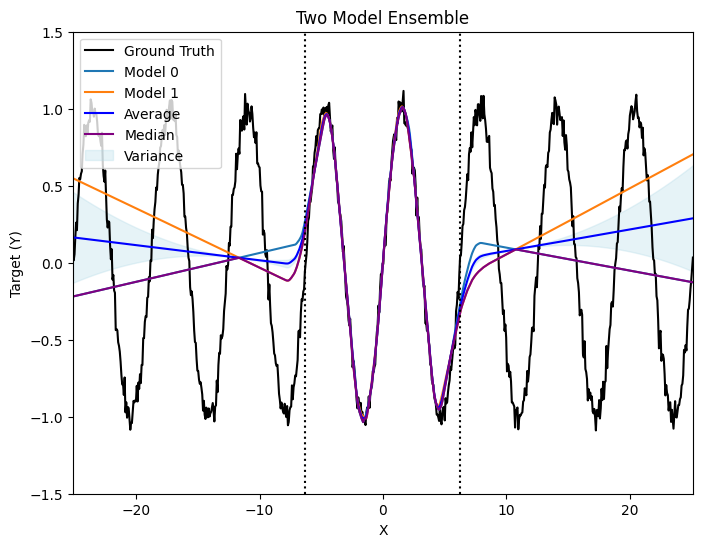

In [16]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")
plt.plot(oos_xs, two_model_outputs[0], label="Model 0")
plt.plot(oos_xs, two_model_outputs[1], label="Model 1")

# Plotting Average and Median
plt.plot(oos_xs, two_model_averages, c="blue", label="Average")
plt.plot(oos_xs, two_model_medians, c="purple", label="Median")

# Plotting Bounding Lines for Variance
# Note: You need to adjust the index for two_model_var based on your actual data structure
plt.fill_between(oos_x_flat, torch.tensor(two_model_averages) - torch.tensor(two_model_var), torch.tensor(two_model_averages) + torch.tensor(two_model_var), color='lightblue', alpha=0.3, label='Variance')

plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)

plt.ylim(-1.5, 1.5)
plt.title('Two Model Ensemble')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()

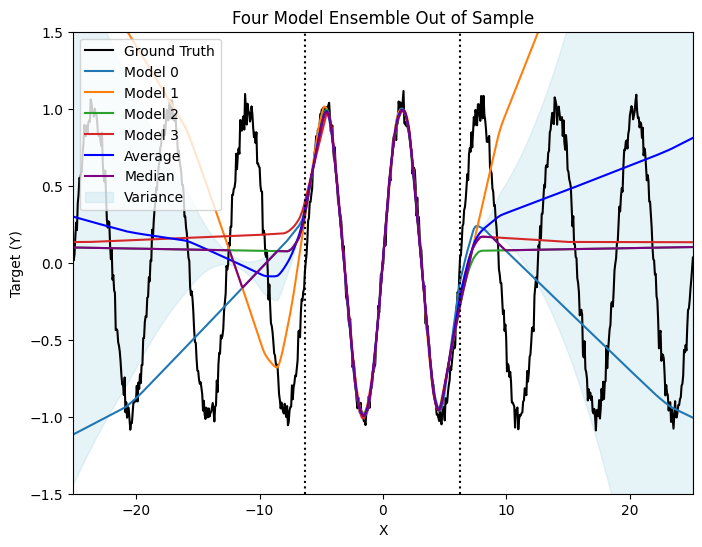

In [17]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")

# Plot individual models
for i, model_output in enumerate(four_model_outputs):
    plt.plot(oos_xs, model_output, label=f"Model {i}")

# Plot posterior predictive (average and median)
plt.plot(oos_xs, four_model_averages, c="blue", label="Average")
plt.plot(oos_xs, four_model_medians, c="purple", label="Median")

# Plotting Bounding Lines for Variance
# Note: You need to adjust the index for four_model_var based on your actual data structure
plt.fill_between(oos_x_flat, torch.tensor(four_model_averages) - torch.tensor(four_model_var), torch.tensor(four_model_averages) + torch.tensor(four_model_var), color='lightblue', alpha=0.3, label='Variance')

plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.title('Four Model Ensemble Out of Sample')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


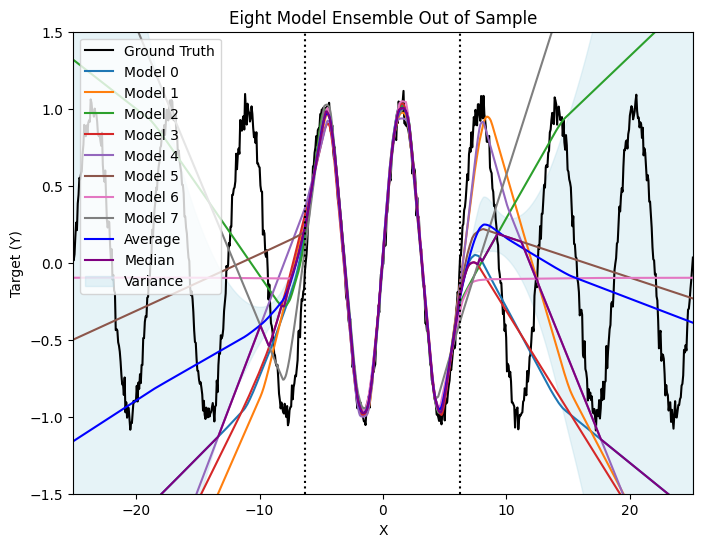

In [18]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")

# Plot individual models
for i, model_output in enumerate(eight_model_outputs):
    plt.plot(oos_xs, model_output, label=f"Model {i}")

# Plot posterior predictive (average and median)
plt.plot(oos_xs, eight_model_averages, c="blue", label="Average")
plt.plot(oos_xs, eight_model_medians, c="purple", label="Median")

# Plotting Bounding Lines for Variance
# Note: You need to adjust the index for eight_model_var based on your actual data structure
plt.fill_between(oos_x_flat, torch.tensor(eight_model_averages) - torch.tensor(eight_model_var), torch.tensor(eight_model_averages) + torch.tensor(eight_model_var), color='lightblue', alpha=0.3, label='Variance')

plt.title('Eight Model Ensemble Out of Sample')
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()

References:

[1] A.G. Wilson, P. Izmailov. Bayesian Deep Learning and a Probabilistic Perspective of Generalization. Advances in Neural Information Processing Systems, 2020.